## Import Libraries

In [154]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

## Import Datasets

In [155]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [156]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [157]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names

### Sort columns by the attributes 'id' and 'cycle'

In [158]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'

In [159]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)


### Normalize test data in all columns that are different to 'id' and 'cycle'

In [160]:
norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [161]:
# Create a column for the RUL
rul = pd.DataFrame(train_data.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_data = train_data.merge(rul, on=['id'], how='left')
train_data['RUL'] = train_data['max'] - train_data['cycle']
train_data.drop('max', axis=1, inplace=True)

# Create a column for the RUL
rul = pd.DataFrame(test_data.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
test_data = test_data.merge(rul, on=['id'], how='left')
test_data['RUL'] = test_data['max'] - test_data['cycle']
test_data.drop('max', axis=1, inplace=True)



In [162]:
# Remove columns with only one unique value
train_data = train_data.loc[:, train_data.apply(pd.Series.nunique) != 1]
test_data = test_data.loc[:, test_data.apply(pd.Series.nunique) != 1]

# remove sensor 6, setting 1 and setting 2
train_data = train_data.drop(['s6', 'setting1', 'setting2'], axis=1)
test_data = test_data.drop(['s6', 'setting1', 'setting2'], axis=1)

# Fill missing values with the mean
train_data = train_data.fillna(train_data.mean())

In [163]:
# smooth the data using rolling average
train_data_smooth = train_data.copy()
train_data_smooth.iloc[:, 2:21] = train_data_smooth.iloc[:, 2:21].rolling(window=5).median()
train_data_smooth = train_data_smooth.dropna()

test_data_smooth = test_data.copy()
test_data_smooth.iloc[:, 2:21] = test_data_smooth.iloc[:, 2:21].rolling(window=5).median()
test_data_smooth = test_data_smooth.dropna()

C:\Users\neche\AppData\Local\Temp\ipykernel_5424\54325391.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0          NaN
1          NaN
2          NaN
3          NaN
4        189.0
         ...  
20626      6.0
20627      5.0
20628      4.0
20629      3.0
20630      2.0
Name: RUL, Length: 20631, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_smooth.iloc[:, 2:21] = train_data_smooth.iloc[:, 2:21].rolling(window=5).median()
C:\Users\neche\AppData\Local\Temp\ipykernel_5424\54325391.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         NaN
1         NaN
2         NaN
3         NaN
4        28.0
         ... 
13091     6.0
13092     5.0
13093     4.0
13094     3.0
13095     2.0
Name: RUL, Length: 13096, dtype: float64' has dtype incompatible with int64, please explicitl

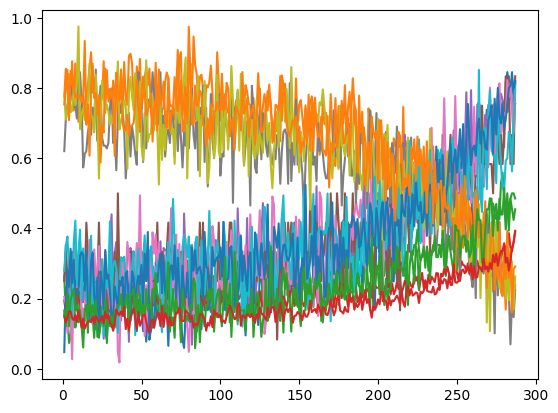

In [164]:
# EDA
# Plot Sensor data in relation to cycles

# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL']):
    plt.plot(train_data[train_data["id"] == 2]["cycle"], train_data[i][train_data["id"] == 2], label=i)
    #plt.show()
    #print(i)


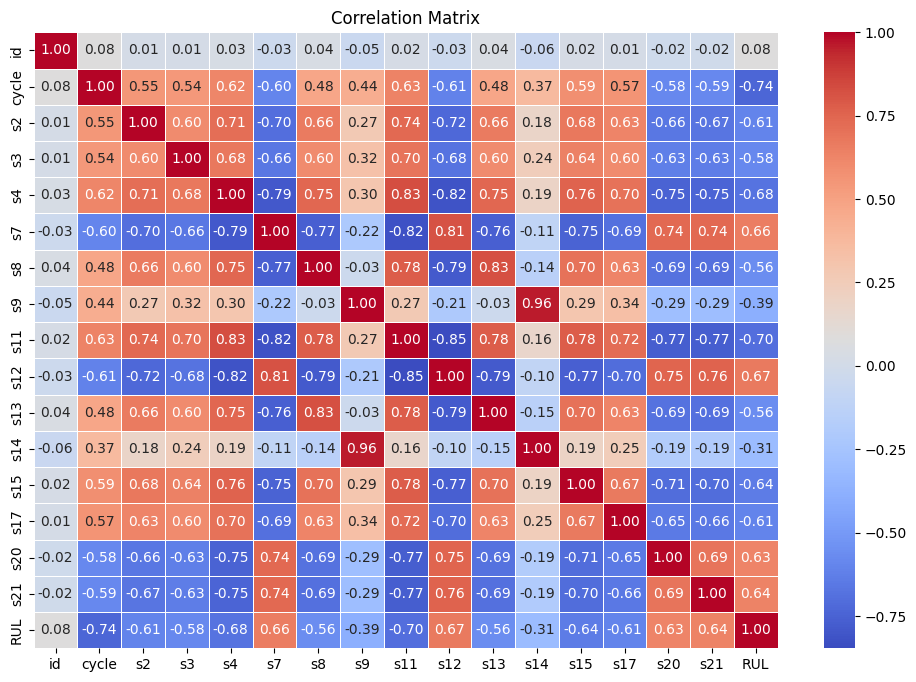

In [165]:
# Compute the correlation matrix
corr = train_data.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [166]:
# Remove s9, s13, s8, s3 and s14 as they dont have a high correlation with the RUL
train_data = train_data.drop(['s9', 's14'], axis=1)
test_data = test_data.drop(['s9', 's14'], axis=1)

In [167]:
# Set up the data for the model
X_train = train_data_smooth.drop(['RUL'], axis=1)
X_test = test_data_smooth.drop(['RUL'], axis=1)

y_train = train_data_smooth['RUL']
y_test = test_data_smooth['RUL']

In [168]:
# Training the model	
# Adding Dropout layers for regularization
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Visualizing learning curves
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 5800.1616 - val_loss: 3084.4983
Epoch 2/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 1417.9718 - val_loss: 2700.0161
Epoch 3/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 1216.9923 - val_loss: 2498.5654
Epoch 4/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - loss: 1149.8380 - val_loss: 2450.5820
Epoch 5/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - loss: 1144.7931 - val_loss: 2661.1396
Epoch 6/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - loss: 1142.7751 - val_loss: 2485.4968
Epoch 7/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 1101.6809 - val_loss: 2440.5959
Epoch 8/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 1075.4606 - val_loss: 2432.6855
Epoch 9/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 1064.0442 - val_loss: 2427.3594
Epoch 10/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - loss: 1028.1036 - val_loss: 2313.9468
Epoch 11/30
1032/1032 ━━━━━━━━━━━━━━━━━

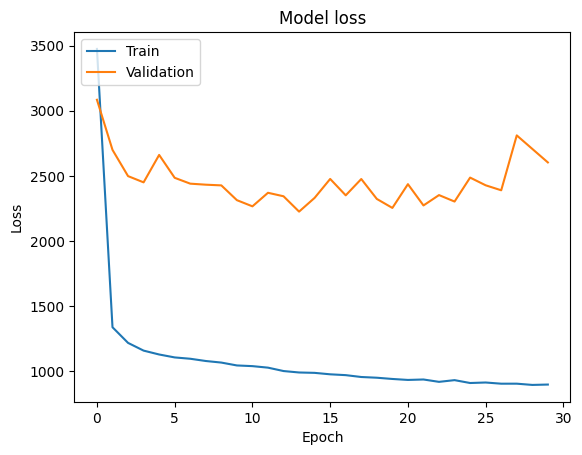

410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
RMSE:  61.729906236786384
MAE:  48.192077282833246
R^2 score:  -0.3566880569994111


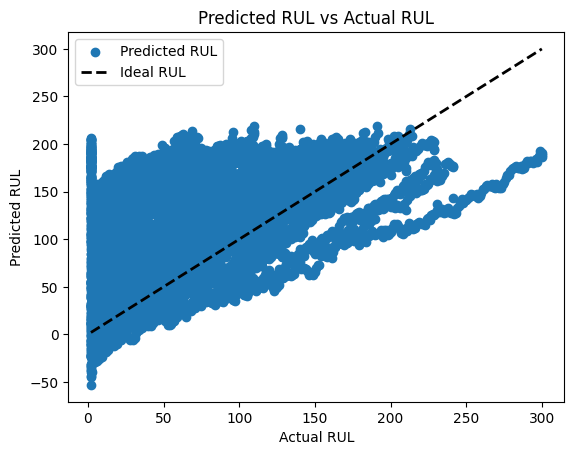

In [171]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Map the RUL to the test data
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 score: ', r2)

# Plot the predicted RUL vs the actual RUL
plt.scatter(y_test, y_pred, label='Predicted RUL')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal RUL')
plt.title('Predicted RUL vs Actual RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.show()